In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

In [3]:
res = gpd.read_file(r'../Data/processed/manhattan_residential.geojson')

In [4]:
manhattan = gpd.read_file(r'../Data/processed/manhattan_buildings.geojson')

In [5]:
# res = manhattan[(manhattan['CURTAXCLASS'].isin([1, 2]))].copy()

In [6]:
class_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'S': 5}

# extract first letter and map
res['BLDG_CLASS_NUM'] = res['BLDG_CLASS'].str[0].map(class_map).fillna(6).astype(int)

In [7]:
res.columns

Index(['base_bbl', 'construction_year', 'height_roof', 'bin', 'CURTAXCLASS',
       'CURMKTTOT', 'PYMKTTOT', 'GROSS_SQFT', 'RESIDENTIAL_AREA_GROSS',
       'BLD_STORY', 'ZONING', 'BLDG_CLASS', 'price_per_sqft',
       'price_per_sqft_2024', 'time_taken', 'elevator', 'unitsres',
       'res_share', 'elevator_flag', 'price_inc', 'geometry',
       'BLDG_CLASS_NUM'],
      dtype='object')

In [8]:
# clustering 1
K = 5
RANDOM_STATE = 42

In [9]:
def kmeans_and_profile_fast(df, k=6, random_state=42, weights=None, stats=("min","median","mean","max")):
    feat_cols = [
        "construction_year",
        "height_roof",
        "price_per_sqft",
        "BLDG_CLASS_NUM",
    ]
    
    weights = np.array([
        4,   # construction_year
        2,   # height_roof
        1,   # price_per_sqft
        1,   # BLDG_CLASS_NUM
    ], dtype=np.float32)

    df[feat_cols] = (
        df[feat_cols]
        .apply(pd.to_numeric, errors="coerce")
        .replace([np.inf, -np.inf], np.nan)
        .astype(np.float32)
    )
    X = df[feat_cols].to_numpy(dtype=np.float32)

    imp = SimpleImputer(strategy="median")
    X_imp = imp.fit_transform(X).astype(np.float32)

    q01 = np.nanpercentile(X_imp, 1, axis=0)
    q99 = np.nanpercentile(X_imp, 99, axis=0)
    X_clip = np.clip(X_imp, q01, q99).astype(np.float32)

    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_clip).astype(np.float32)

    X_w = (X_scaled * weights).astype(np.float32)

    km = KMeans(n_clusters=k, n_init=10, algorithm="elkan", random_state=random_state)
    labels = km.fit_predict(X_w)

    # --- Stable relabeling by mean height_roof ---
    label_order = (
        pd.DataFrame({"label": labels, "construction_year": df["construction_year"]})
        .groupby("label")["construction_year"]
        .mean()
        .sort_values()
        .index
        .tolist()
    )
    remap = {old: new for new, old in enumerate(label_order)}
    labels = np.array([remap[l] for l in labels], dtype=np.int32)

    df = df.assign(kmeans_label=labels)

    all_df = km.transform(X_w).astype(np.float32)
    chosen_df = all_df[np.arange(all_df.shape[0]), km.labels_]
    r90 = {c: np.nanpercentile(chosen_df[labels == c], 90) for c in range(k)}
    r95 = {c: np.nanpercentile(chosen_df[labels == c], 95) for c in range(k)}
    conf = 1.0 - np.minimum(
        chosen_df / np.array([r90[c] for c in labels], dtype=np.float32),
        1.0
    )
    df = df.assign(cluster_confidence=conf.astype(np.float32))

    X_clip_df = pd.DataFrame(X_clip, columns=feat_cols, index=df.index)
    X_clip_df["kmeans_label"] = labels
    agg = {c: list(stats) for c in feat_cols}
    prof = X_clip_df.groupby("kmeans_label").agg(agg)
    prof[("n","count")] = X_clip_df.groupby("kmeans_label").size()
    cols = [("n","count")] + [c for c in prof.columns if c != ("n","count")]
    prof = prof.reindex(columns=cols)

    return {
        "data": df,
        "model": km,
        "scaler": scaler,
        "imputer": imp,
        "feature_weights": dict(zip(feat_cols, weights.tolist())),
        "cluster_profile": prof,
        "r90": r90,
        "r95": r95,
    }


In [10]:
results = kmeans_and_profile_fast(res, k=K, random_state=RANDOM_STATE)
manhattan_k = results["data"]
profile = results["cluster_profile"]

In [11]:
print(profile['construction_year'])

                 min  median         mean     max
kmeans_label                                     
0             1835.0  1885.0  1877.897583  1948.0
1             1865.0  1910.0  1911.246216  1952.0
2             1860.0  1940.0  1940.242310  2003.0
3             1890.0  1986.0  1986.221924  2022.0
4             1951.0  1998.0  1991.608032  2022.0


In [12]:
print(profile['height_roof'])

                     min      median        mean         max
kmeans_label                                                
0              14.150562   46.710239   49.116287  136.910004
1              14.150562   60.000000   60.441463  137.714935
2              91.070000  161.630005  162.194382  282.017578
3             198.026382  320.170013  316.237701  390.000000
4              14.150562   65.620003   71.704033  195.000000


In [13]:
print(profile['price_per_sqft'])

                    min       median         mean          max
kmeans_label                                                  
0             33.828571  2001.736084  2016.193848  3217.528809
1             33.828571   236.290833   307.928284  3217.528809
2             33.828571   218.447861   209.368011   704.659973
3             33.828571   258.627960   241.043228   581.089294
4             33.828571   246.783417   363.618713  3217.528809


In [14]:
print(profile['BLDG_CLASS_NUM'])

              min  median      mean  max
kmeans_label                            
0             1.0     2.0  1.972843  5.0
1             1.0     3.0  3.180349  5.0
2             4.0     4.0  4.000000  4.0
3             3.0     4.0  3.997514  4.0
4             1.0     4.0  3.674821  5.0


In [15]:
cluster_names = {
    0: "Old luxury houses",
    1: "Early 20th century multi family lowrise",
    2: "Mid 20th Century midrise",
    3: "Modern affordable highrise",
    4: "Contemporary premium lowrise"
}

# Apply mapping to your dataframe
results["data"]["cluster_name"] = results["data"]["kmeans_label"].map(cluster_names)

# Also add to profile for easier readability
profile_named = results["cluster_profile"].copy()
profile_named.index = profile_named.index.map(cluster_names)

In [16]:
res_socio = results['data']
res_socio.columns

Index(['base_bbl', 'construction_year', 'height_roof', 'bin', 'CURTAXCLASS',
       'CURMKTTOT', 'PYMKTTOT', 'GROSS_SQFT', 'RESIDENTIAL_AREA_GROSS',
       'BLD_STORY', 'ZONING', 'BLDG_CLASS', 'price_per_sqft',
       'price_per_sqft_2024', 'time_taken', 'elevator', 'unitsres',
       'res_share', 'elevator_flag', 'price_inc', 'geometry', 'BLDG_CLASS_NUM',
       'kmeans_label', 'cluster_confidence', 'cluster_name'],
      dtype='object')

In [17]:
res_socio['cluster_name'].value_counts()

cluster_name
Early 20th century multi family lowrise    125540
Old luxury houses                           30195
Mid 20th Century midrise                    26208
Contemporary premium lowrise                16025
Modern affordable highrise                   9653
Name: count, dtype: int64

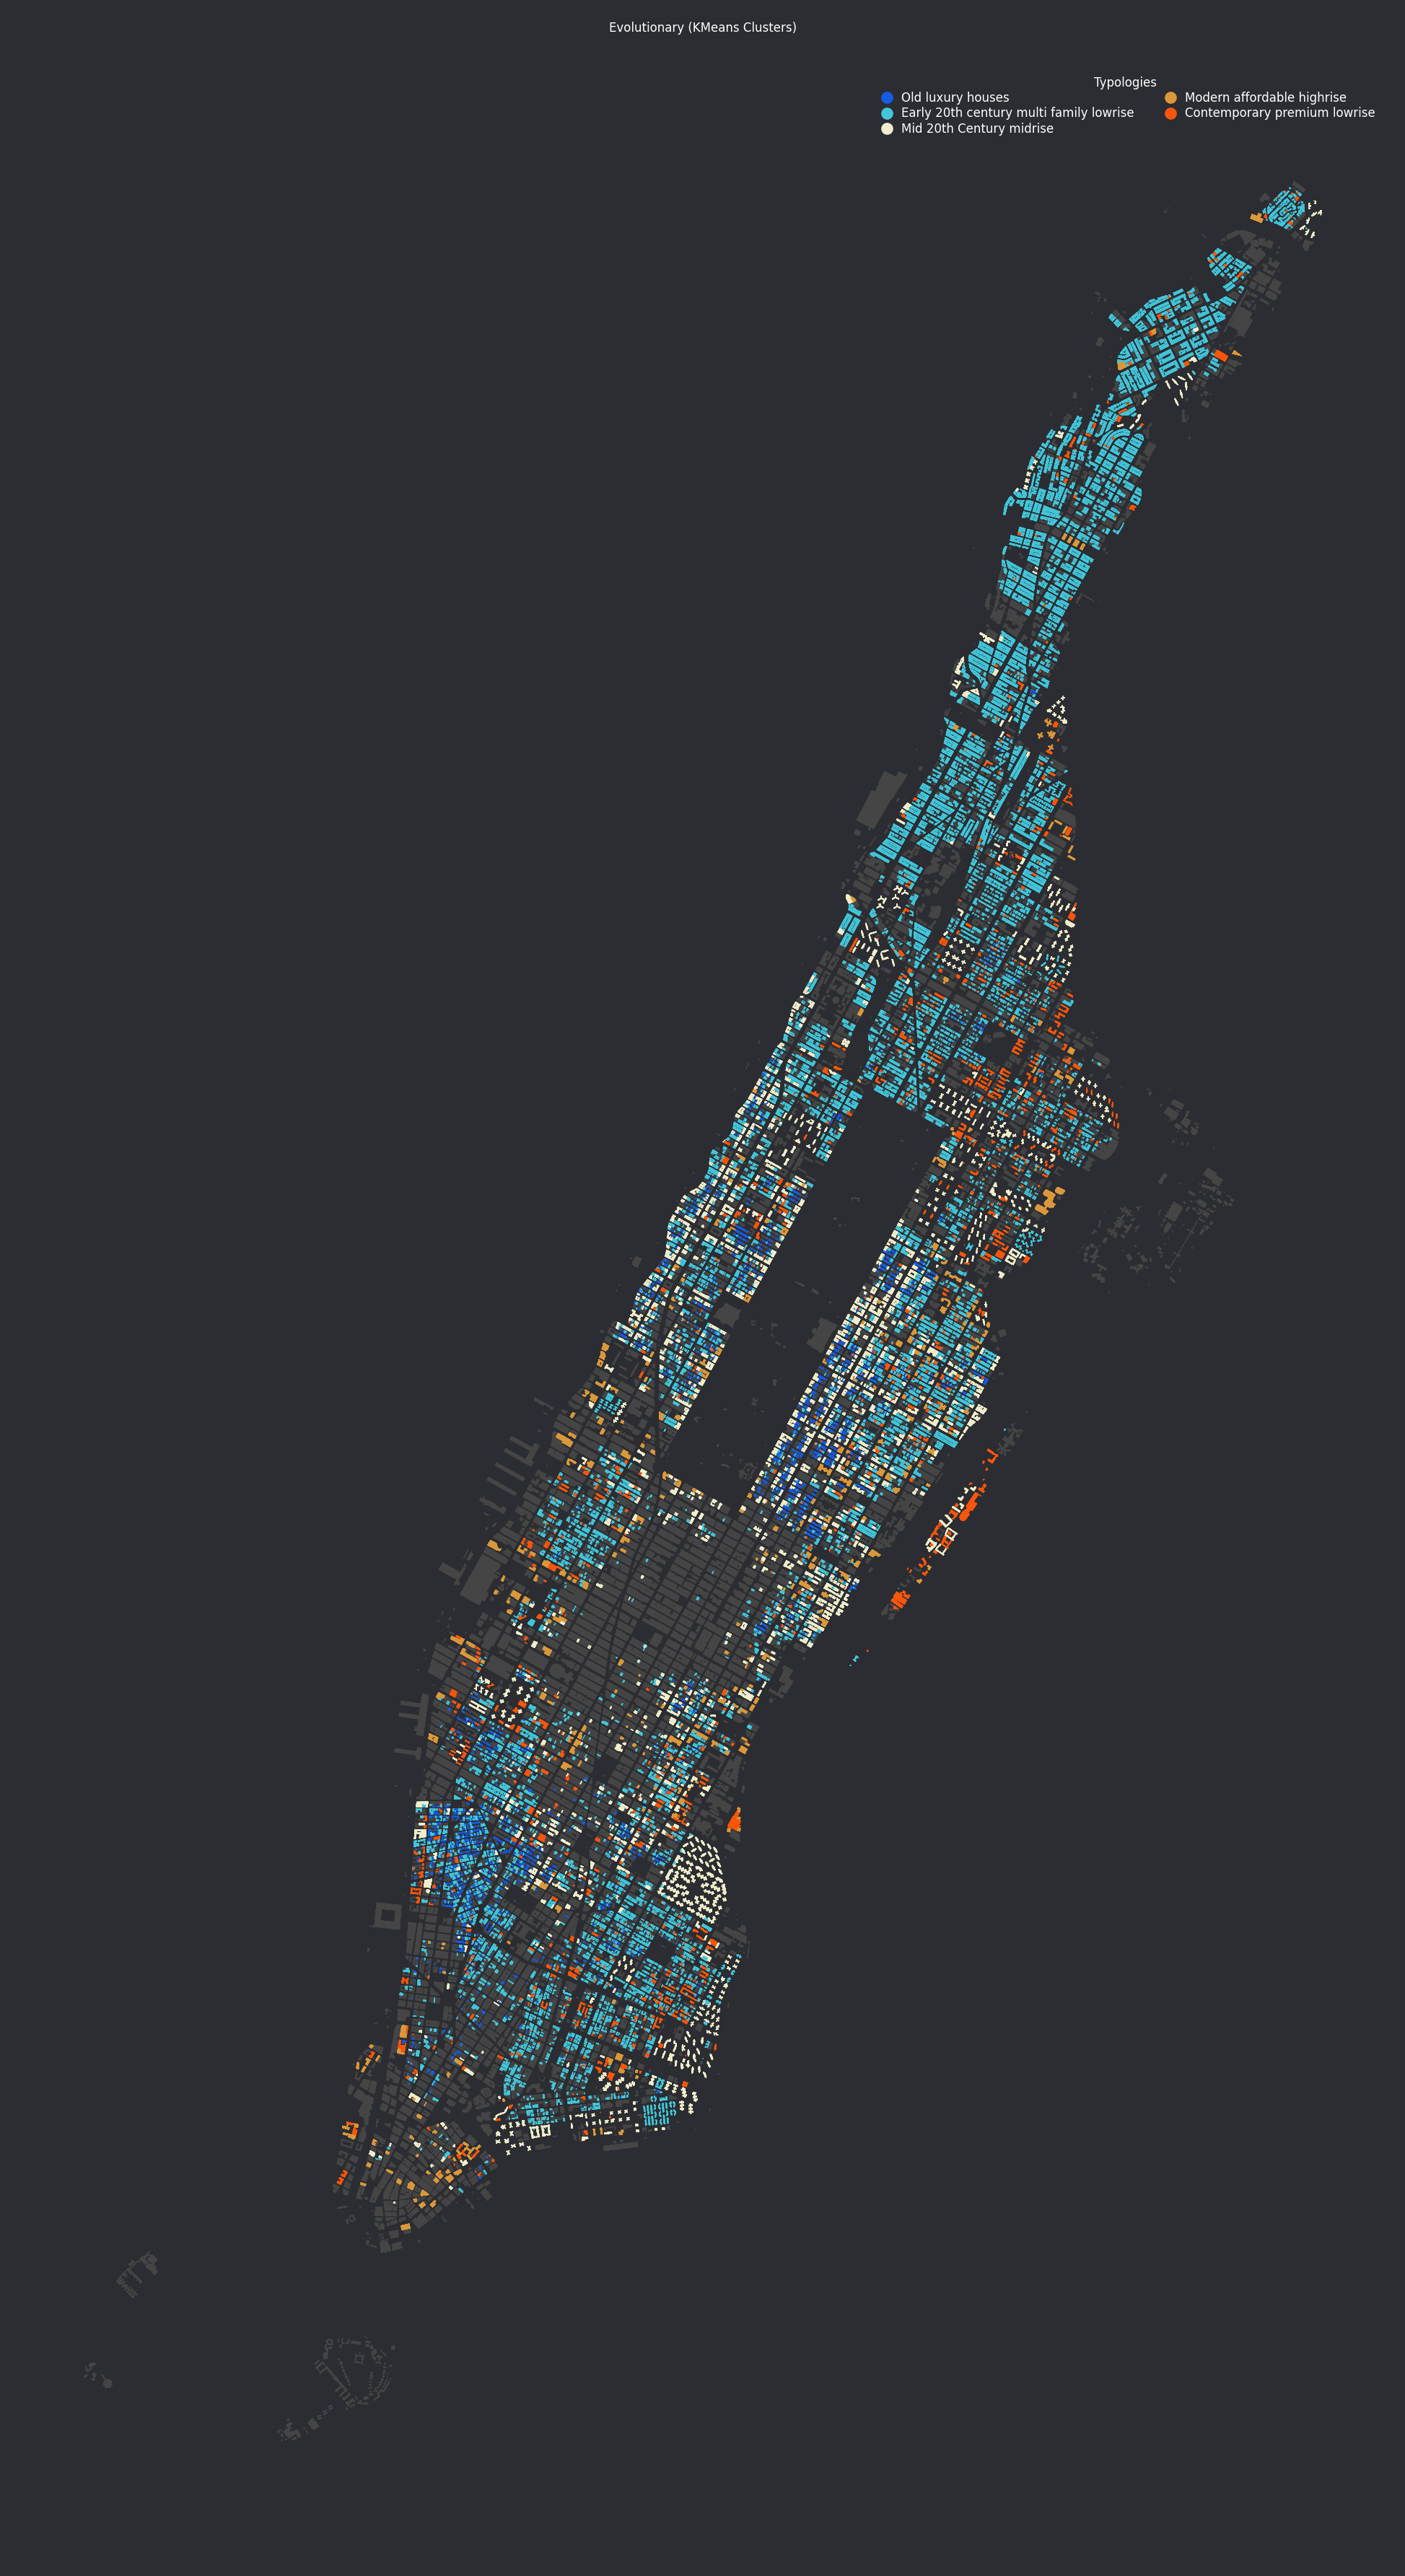

In [18]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pandas.api.types import CategoricalDtype

# --- base layers ---
nonres = manhattan[~manhattan['CURTAXCLASS'].isin([1, 2])]

# define the 6 cluster labels in order
cluster_labels = [
    "Old luxury houses",
    "Early 20th century multi family lowrise",
    "Mid 20th Century midrise",
    "Modern affordable highrise",
    "Contemporary premium lowrise"
]

# mapping dictionary (0–5 → name)
cluster_names = dict(enumerate(cluster_labels))

# assign cluster names into your residential dataframe
# assumes you already have a column "kmeans_label" in res_socio
res_socio["bldg_cat_socio_spatial"] = res_socio["kmeans_label"].map(cluster_names)

# custom colors for the 6 clusters
custom_colors = {
    "Old luxury houses":                               "#175ce5",
    "Early 20th century multi family lowrise":         "#43c6da",
    "Mid 20th Century midrise":                        "#f0edcc",
    "Modern affordable highrise":                      "#da983b",
    "Contemporary premium lowrise":                    "#f6560c",
}

# enforce categorical order
cat_dtype = CategoricalDtype(categories=cluster_labels, ordered=True)
res_socio["bldg_cat_socio_spatial"] = res_socio["bldg_cat_socio_spatial"].astype(cat_dtype)

# colormap in the same order as cluster_labels
color_list = [custom_colors[c] for c in cluster_labels]
cmap = ListedColormap(color_list)

# ---- plot ----
fig, ax = plt.subplots(figsize=(10, 12), dpi=300, facecolor="#2B2D32")

# 1) BASE: non-residential in black
nonres.plot(ax=ax, color="#454545", linewidth=0, edgecolor="none")

# 2) RESIDENTIAL: 6 clusters
res_socio.plot(
    ax=ax,
    column="bldg_cat_socio_spatial",
    cmap=cmap,
    linewidth=0,
    edgecolor="none",
    legend=True,
    categorical=True,
    legend_kwds={
        "title": "Typologies",
        "fontsize": 4,
        "title_fontsize": 4,
        "ncol": 2,
        "markerscale": 0.4,
        "handletextpad": 0.2,
        "labelspacing": 0.2,
        "borderpad": 0.2,
        "frameon": False,
    },
)

ax.set_title("Evolutionary (KMeans Clusters)", color="white", fontsize=4, pad=12)
ax.set_axis_off()

leg = ax.get_legend()
if leg:
    for txt in leg.get_texts():
        txt.set_color("white")
    if leg.get_title() is not None:
        leg.get_title().set_color("white")

plt.tight_layout()
plt.show()


In [19]:
fig.savefig('evolutionary.png', dpi=300, transparent=True)
plt.close(fig)